# Crime rate classification task
## In this lab I will develop a model to determine whether a given suburb has a crime rate above or below the median by using multiple combinations of predictors to explore various classification models such as `logistic regression`, `linear discriminant analysis`, `Quadratic discriminant analysis`, `naive bayes`, and `K-nearest neighbors` to determine which model is most suitable for the task at hand.
## For this approach I will follow a  combination of wrapper feature selection and statistical-based feature selection for univariate and multivariate analysis.
### **1. Importing libraries and loading data**

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS, summarize)
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, 
                                           QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from ISLP import load_data

In [40]:
Boston = load_data('Boston')
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [41]:
print('shape:', Boston.shape)

shape: (506, 13)


### This data set consists of 506 properties in Boston with 12 predictors to determine the crime rate.
### For this task we classify crime rate as above or below the median crime rate.

In [42]:
Boston['crim'].median()

0.25651

In [43]:
# Creating classification class
Boston['crim_class'] = np.where(Boston['crim'] > Boston['crim'].median(), 1, 0)
Boston.sample(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv,crim_class
62,0.11027,25.0,5.13,0,0.4530,6.456,67.8,7.2255,8,284,19.7,6.73,22.2,0
435,11.16040,0.0,18.10,0,0.7400,6.629,94.6,2.1247,24,666,20.2,23.27,13.4,1
488,0.15086,0.0,27.74,0,0.6090,5.454,92.7,1.8209,4,711,20.1,18.06,15.2,0
411,14.05070,0.0,18.10,0,0.5970,6.657,100.0,1.5275,24,666,20.2,21.22,17.2,1
279,0.21038,20.0,3.33,0,0.4429,6.812,32.2,4.1007,5,216,14.9,4.85,35.1,0


### With a median crime rate of 0.256, any value above the median is classified as having a high crime rate  (denoted as 1) and low crime rate otherwise (denoted as 0).
### **2. Statistical analysis**
### I will first conduct a statistical analysis to develop various combinations for a wrapper feature selection. This will be done by investigating the predictors statistical significance to the target using the pearson correlation coefficient as pre-selection. This is followed by a univariate analysis to measure the p-value and t-statistic of the chosen features for further investigation of statistical significance.

In [56]:
# Class distribution
Boston['crim_class'].value_counts()

0    253
1    253
Name: crim_class, dtype: int64

In [45]:
Boston = Boston.drop(columns= 'crim')
corr = Boston.corr()
corr['crim_class'].sort_values(ascending= False)

crim_class    1.000000
nox           0.723235
rad           0.619786
age           0.613940
tax           0.608741
indus         0.603260
lstat         0.453263
ptratio       0.253568
chas          0.070097
rm           -0.156372
medv         -0.263017
zn           -0.436151
dis          -0.616342
Name: crim_class, dtype: float64

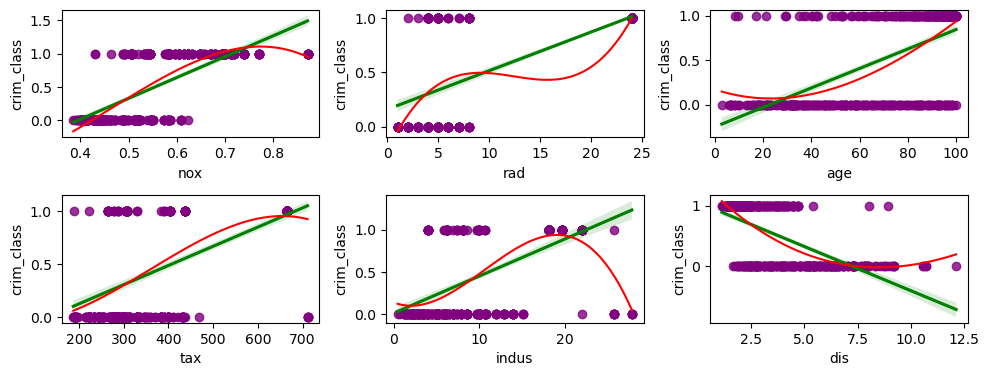

In [55]:
plt.figure(figsize=(10, 9))

predictors = ['nox', 'rad', 'age', 'tax', 'indus', 'dis']

for i, predictor in enumerate(predictors):
    X = np.column_stack((Boston[predictor], np.power(Boston[predictor], 2), np.power(Boston[predictor], 3)))
    y = Boston['crim_class']
    model = sm.OLS(y, sm.add_constant(X))  # Add constant for the intercept
    rslt = model.fit()
    
    plt.subplot(5, 3, i + 1)
    sns.regplot(x= predictor, y= 'crim_class', data= Boston, color= 'purple', line_kws= {'color': 'green'})
    plt.xlabel(predictor)
    plt.ylabel('crim_class')
    
    # Plot the full polynomial regression line
    x = np.linspace(min(Boston[predictor]), max(Boston[predictor]), 100)
    X_pred = np.column_stack((x, x**2, x**3))
    y_pred = rslt.predict(sm.add_constant(X_pred))
    plt.plot(x, y_pred, color= 'red')

plt.tight_layout()
plt.show()


### Using the correlation coefficients with a threshold of 0.6, we observe evidence of a relationship existing between nox, rad, age, tax, indus, dis and the crime rate. It is important to note the relationships do not have a strong correlation.
### Using the graphs, we can test for non-linearity. The green line represents the regression line and the red line represents a polynomial regression. The regression line fits the data fairly well in relation to the polynomial regression for most predictors, but we do however observe evidence for non-linearity. Using this information, we can assume that non-linear classification methods such as the KNN and the QDA will give us the best results.
### The selected predictors are then used for a univariate analysis using a linear regression. 
### **Univariate analysis**

In [47]:
# Printing the table header with t-statistic and p-value
print('{:>} {:>22} {:>24}'.format('predictor', 't-statistic', 'pvalue'))

# Initialize an empty dictionary to store t-statistic values
t_statistics = {}
predictors = Boston[['nox', 'rad', 'age', 'tax', 'indus', 'dis']]

# Loop through each predictor and perform a univariate linear regression
for predictor in predictors:
    X = MS([predictor]).fit_transform(Boston)
    y = Boston['crim_class']
    model = sm.OLS(y, X)
    rslt = model.fit()
    
    # Print the predictor name, t-statistic, and p-value
    print('{:>9} {:>22} {:>24.2f}'.format(predictor, rslt.tvalues[predictor], rslt.pvalues[predictor]))
    
    # Store the t-statistic value for the predictor in the 't_statistics' dictionary
    t_statistics[predictor] = [rslt.tvalues[predictor]]

predictor            t-statistic                   pvalue
      nox      23.51075673403978                     0.00
      rad     17.730232922074535                     0.00
      age     17.461036180347634                     0.00
      tax     17.225542434471055                     0.00
    indus     16.981068698797316                     0.00
      dis    -17.571056137083076                     0.00


### All 6 predictors appear to be statistically significant to the target. The negative t-statistic is indicative of the negative slope/relationship between crime rate and dis. The predictors have a p-value less than 0.05 therefore we can reject the null hypotheses (which states that there is no relationship between the predictors and the target).
### I will then conduct a multivariate analysis using a multiple linear regression to determine if there is any association between the predictors.
### It is important to note that the correlation coefficient and the graphs provided evidence for non-linearity, so a multiple linear regression might not be able to capture the true relationship between the predictors. 
### **Multivariate analysis**

In [48]:
X = MS(predictors).fit_transform(Boston)
model = sm.OLS(y, X)
rslt = model.fit()
rslt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             crim_class   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     120.5
Date:                Tue, 22 Aug 2023   Prob (F-statistic):           9.45e-94
Time:                        12:52:31   Log-Likelihood:                -140.60
No. Observations:                 506   AIC:                             295.2
Df Residuals:                     499   BIC:                             324.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.6778      0.151     -4.489      0.000      -0.974      -0.381
nox            1.7549      0.241      7.280      0.000       1.281       2.228
rad            0.0222      0.004      5.371      0.000       0.014       0.030
age            0.0027      0.001      3.323      0.001       0.001       0.004
tax           -0.0004      0.000     -1.701      0.090      -0.001    6.48e-05
indus          0.0020      0.004      0.503      0.615      -0.006       0.010
dis           -0.0126      0.012     -1.031      0.303      -0.037       0.011
==============================================================================
Omnibus:                       31.950   Durbin-Watson:                   0.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.768
Skew:                           0.653   Prob(JB):                     1.04e-08
Kurtosis:                       2.808   Cond. No.                     8.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### The multivariate linear regression has an R-sqaured of 0.592, that is to say 59.2% of changes in crime rate can be explained by the combination of these predictors (this can be simplified by thinking of the model as being 59.2% accurate).
### We do however note that tax, indus and dis have increased p-values which is higher than 0.05,  therefore we can not reject the null hypothesis for this predictors. This is known as the confounding effect. 
### By removing these three predictors we can apply a wrapper model selection by comparing the performance of the different combinations of predictors. The first one using only nox, rad, and age determined by the multivariate analysis, the second using the 6 predictors that were pre-selected using pearson correlation and univariate analysis, and lastly using all 12 predictors contained in the data set.
### **3. Classification algorithms**
### I will test various classification methods to determine which algorithm and combination of predictors is most suitable in predicting whether a certain suburb has a crime rate above or below the median crime rate in Boston.
### I will seperate the data into training and test sets to test which algortithm performs the best on unseen data. This will be measured by the accuracy score.
### **Linear discriminant analysis**

In [49]:
Xsm = Boston[['nox', 'rad', 'age']]
Xlm = Boston[['nox', 'rad', 'age', 'tax', 'indus', 'dis']]
Xall = Boston.drop(columns= 'crim_class')

Xsm_train, Xsm_test, y_train, y_test = train_test_split(Xsm, y, test_size= 0.2,random_state= 0)
Xlm_train, Xlm_test, y_train, y_test = train_test_split(Xlm, y, test_size= 0.2,random_state= 0)
Xall_train, Xall_test, y_train, y_test = train_test_split(Xall, y, test_size= 0.2,random_state= 0)

# Linear discriminant analysis
lda = LDA()
lda = lda.fit(Xsm_train, y_train)
lda_pred = lda.predict(Xsm_test)
lda_accuracy = accuracy_score(y_test, lda_pred)
print('Small model accuracy: {:.2f}'.format(lda_accuracy * 100)) 

lda = lda.fit(Xlm_train, y_train)
lda_pred = lda.predict(Xlm_test)
lda_accuracy = accuracy_score(y_test, lda_pred)
print('Large model accuracy: {:.2f}'.format(lda_accuracy * 100)) 

lda = lda.fit(Xall_train, y_train)
lda_pred = lda.predict(Xall_test)
lda_accuracy = accuracy_score(y_test, lda_pred)
print('Full model accuracy: {:.2f}'.format(lda_accuracy * 100))

Small model accuracy: 86.27
Large model accuracy: 86.27
Full model accuracy: 88.24


### **Logistic regression**

In [50]:
# Logistic regression analysis
logreg = LogisticRegression()
logreg = logreg.fit(Xsm_train, y_train)
logreg_pred = logreg.predict(Xsm_test)
logreg_accuracy = accuracy_score(y_test, logreg_pred)
print('Small moodel accuracy: {:.2f}'.format(logreg_accuracy * 100)) 

logreg = logreg.fit(Xlm_train, y_train)
logreg_pred = logreg.predict(Xlm_test)
logreg_accuracy = accuracy_score(y_test, logreg_pred)
print('Large model accuracy: {:.2f}'.format(logreg_accuracy * 100)) 

logreg = logreg.fit(Xall_train, y_train)
logreg_pred = logreg.predict(Xall_test)
logreg_accuracy = accuracy_score(y_test, logreg_pred)
print('Full model accuracy: {:.2f}'.format(logreg_accuracy * 100)) 

Small moodel accuracy: 82.35
Large model accuracy: 86.27


Full model accuracy: 85.29


c:\Users\Dolf\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Dolf\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

### **Naive bayes**

In [52]:
# Naive bayes
nb = GaussianNB()
nb = nb.fit(Xsm_train, y_train)
nb_pred = nb.predict(Xsm_test)
nb_accuracy = accuracy_score(y_test, nb_pred)
print('Small model accuracy: {:.2f}'.format(nb_accuracy * 100)) 

nb = nb.fit(Xlm_train, y_train)
nb_pred = nb.predict(Xlm_test)
nb_accuracy = accuracy_score(y_test, nb_pred)
print('Large model accuracy: {:.2f}'.format(nb_accuracy * 100)) 

nb = nb.fit(Xall_train, y_train)
nb_pred = nb.predict(Xall_test)
nb_accuracy = accuracy_score(y_test, nb_pred)
print('Full model accuracy: {:.2f}'.format(nb_accuracy * 100)) 

Small model accuracy: 87.25
Large model accuracy: 86.27
Full model accuracy: 83.33


### **Quadratic discriminant analysis**

In [51]:
# Quadratic discriminant analysis
qda = QDA()
qda = qda.fit(Xsm_train, y_train)
qda_pred = qda.predict(Xsm_test)
qda_accuracy = accuracy_score(y_test, qda_pred)
print('Small model accuracy: {:.2f}'.format(qda_accuracy * 100)) 

qda = qda.fit(Xlm_train, y_train)
qda_pred = qda.predict(Xlm_test)
qda_accuracy = accuracy_score(y_test, qda_pred)
print('Large model accuracy: {:.2f}'.format(qda_accuracy * 100)) 

qda = qda.fit(Xall_train, y_train)
qda_pred = qda.predict(Xall_test)
qda_accuracy = accuracy_score(y_test, qda_pred)
print('Full model accuracy: {:.2f}'.format(qda_accuracy * 100)) 

Small model accuracy: 86.27
Large model accuracy: 90.20
Full model accuracy: 89.22


### **K-nearest neighbour**
### For KNN I will limit the number of K to range between 3 and 9. A K value of 1 or 2 can be prone to overfitting which can render our results unreliable.
### I will create a function that tests for the best value of K for each combination of predictors.

In [53]:
# Get the best k for each model between 3 and 9
def get_knn_accuracy(X_train, X_test, y_train, y_test):
    neighbors = []
    for n in range(3, 10):
        knn = KNeighborsClassifier(n_neighbors=n)
        knn = knn.fit(X_train, y_train)
        knn_pred = knn.predict(X_test)
        knn_accuracy = accuracy_score(y_test, knn_pred)
        neighbors.append(knn_accuracy)
    best_n = max(neighbors)
    best_n = neighbors.index(best_n) + 3
    knn = KNeighborsClassifier(n_neighbors=best_n)
    knn = knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    knn_accuracy = accuracy_score(y_test, knn_pred)
    print('Best k =', best_n)
    return knn_accuracy

knn_accuracy_small = get_knn_accuracy(Xsm_train, Xsm_test, y_train, y_test)
print('Small model accuracy: {:.2f}'.format(knn_accuracy_small * 100))
print(' ')

knn_accuracy_large = get_knn_accuracy(Xlm_train, Xlm_test, y_train, y_test)
print('Large model accuracy: {:.2f}'.format(knn_accuracy_large * 100))
print(' ')

knn_accuracy_full = get_knn_accuracy(Xall_train, Xall_test, y_train, y_test)
print('Full model accuracy: {:.2f}'.format(knn_accuracy_full * 100))


Best k = 9
Small model accuracy: 81.37
 
Best k = 4
Large model accuracy: 92.16
 
Best k = 4
Full model accuracy: 94.12


### **Conclusion**
### As expected from our assumption, we achieve the highest accuracy using non-linear classification methods, namely KNN and QDA. In comparing the best set of predictors, we can attain a 92.16% accuracy using KNN with 4 neighbours and the second combination of predictors that was chosen using the univariate analysis.
### The data showed moderate correlation and provided evidence of non-linearity hence the higher accuracy of non-linear methods. 
### Despite the fuller model having a higher accuracy, a 2% decrease can be considered insignificant in favour of a more efficient model. This also reduces the possibility of overfitting the data by reducing the noise in the data making the predictions more reliable.
### For choosing a suburb that is considered safer it is best to look into suburbs that have been classified as true negative using the results of the confusion matrix.
### **5. Confusion matrix for best model**

In [58]:
# Optimal K-nearest neighbour
knn = KNeighborsClassifier(n_neighbors= 4)
knn = knn.fit(Xlm_train, y_train)

# Confusion matrix
knn_pred = knn.predict(Xlm_test)
knn_cm = confusion_matrix(y_test, knn_pred)
knn_accuracy = accuracy_score(y_test, knn_pred)

print('Confusion matrix:')
print(knn_cm , '\n')
print('Accuracy: {:.2f}'.format(knn_accuracy * 100)) 


Confusion matrix:
[[49  2]
 [ 6 45]] 

Accuracy: 92.16


### 49 suburbs are considered safe.